# Tutorial 5: mRFP Expression Prediction with Encodon

This notebook demonstrates predicting mRFP expression levels using pretrained Encodon models.

## Overview
- **Task**: Predict mRFP expression from mRNA sequences
- **Dataset**: Sanofi mRFP Expression dataset
- **Model**: Pretrained Encodon + Random Forest regressor
- **Method**: EncodonInference wrapper for embedding extraction

## 1. Import Libraries and Setup

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm


warnings.filterwarnings("ignore")

# ML libraries
# Visualization
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV


# Add project paths
sys.path.append("..")

# Import Encodon modules
# Import additional modules for dataset handling
from torch.utils.data import DataLoader

from src.data.codon_bert_dataset import CodonBertDataset
from src.data.metadata import MetadataFields
from src.data.preprocess.codon_sequence import process_item
from src.inference.encodon import EncodonInference
from src.inference.task_types import TaskTypes


# Fix random seed
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ Libraries imported successfully!
PyTorch: 2.8.0a0+34c6371d24.nv25.08
CUDA available: True


In [2]:
# Download mRFP Expression dataset if it doesn't exist

# NOTE: This assumes the notebook was launched from the codon-fm source directory.
# NOTE: otherwise change the path for the `subprocess` launch to correspond to the data_scripts path correctly
import subprocess


data_path = "/data/validation/processed/mRFP_Expression.csv"
root_path = "/data/validation/processed/"
if not os.path.exists(data_path):
    print("📥 Downloading mRFP Expression dataset...")
    try:
        subprocess.run(
            [
                "python",
                "data_scripts/download_preprocess_codonbert_bench.py",
                "--dataset",
                "mRFP_Expression.csv",
                "--output-dir",
                root_path,
            ],
            check=True,
        )
        print("✅ Dataset downloaded and preprocessed successfully!")
    except subprocess.CalledProcessError as e:
        print(f"❌ Error downloading dataset: {e}")
        print("Please ensure the data_scripts are available and run manually if needed.")
else:
    print("✅ Dataset already exists!")

✅ Dataset already exists!


## 2. Load Pretrained Encodon Model

In [ ]:
# download models if necessary
from src.utils.load_checkpoint import download_checkpoint


download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-80M-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1"
)
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-600M-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1"
)
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-1B-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-1B-v1"
)

In [ ]:
# Define checkpoint paths
checkpoint_paths = [
    "/data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1",
    "/data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1",
    "/data/checkpoints/NV-CodonFM-Encodon-TE-Cdwt-1B-v1",
]

checkpoint_path = checkpoint_paths[0]
model_loaded = False
if os.path.exists(checkpoint_path):
    try:
        device = "cuda" if torch.cuda.is_available() else "cpu"

        # Create EncodonInference wrapper
        encodon_model = EncodonInference(
            model_path=checkpoint_path, task_type=TaskTypes.EMBEDDING_PREDICTION, use_transformer_engine=True
        )

        # Configure model
        encodon_model.configure_model()
        encodon_model.to(device)
        encodon_model.eval()

        print(f"✅ Model loaded from: {checkpoint_path}")
        print(f"Device: {device}")
        print(f"Parameters: {sum(p.numel() for p in encodon_model.model.parameters()):,}")

        model_loaded = True
    except Exception as e:
        print(f"Failed to load {checkpoint_path}: {e}")

if not model_loaded:
    print("❌ Could not load any model. Please check checkpoint paths.")

## 3. Load Dataset

In [5]:
# Load mRFP Expression dataset
data_path = "/data/validation/processed/mRFP_Expression.csv"

data_loaded = False
if os.path.exists(data_path):
    try:
        data = pd.read_csv(data_path)
        print(f"✅ Loaded {len(data)} samples from: {data_path}")
        print(f"Columns: {list(data.columns)}")

        if "split" in data.columns:
            print(f"Data splits: {data['split'].value_counts().to_dict()}")

        print(f"Target range: [{data['value'].min():.3f}, {data['value'].max():.3f}]")
        data_loaded = True
    except Exception as e:
        print(f"Failed to load {data_path}: {e}")

if not data_loaded:
    print("❌ Could not load mRFP data")

✅ Loaded 1459 samples from: /data/validation/processed/mRFP_Expression.csv
Columns: ['id', 'ref_seq', 'value', 'dataset', 'split']
Data splits: {'train': 1021, 'val': 219, 'test': 219}
Target range: [7.361, 11.379]


## 4. Data Preprocessing

In [6]:
batch_size = 16
if data_loaded and model_loaded:
    print("=== DATA PREPROCESSING ===")
    # Create dataset
    dataset = CodonBertDataset(
        data_path=data_path,
        tokenizer=encodon_model.tokenizer,
        process_item=lambda seq, tokenizer: process_item(
            seq, context_length=encodon_model.model.hparams.max_position_embeddings, tokenizer=tokenizer
        ),
    )

    print(f"Processing {len(dataset)} sequences")
    print(f"Target range: [{dataset.data['value'].min():.3f}, {dataset.data['value'].max():.3f}]")

    # Create data loader for batch processing
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Extract embeddings using the dataset
    print("\nExtracting embeddings...")
    all_embeddings = []
    all_labels = []

    for batch in tqdm(dataloader):
        batch_input = {
            MetadataFields.INPUT_IDS: batch[MetadataFields.INPUT_IDS].to(encodon_model.device),
            MetadataFields.ATTENTION_MASK: batch[MetadataFields.ATTENTION_MASK].to(encodon_model.device),
        }

        # Extract embeddings
        output = encodon_model.extract_embeddings(batch_input)
        all_embeddings.append(output.embeddings)
        all_labels.append(batch[MetadataFields.LABELS].numpy())

    # Combine all embeddings and labels
    embeddings = np.vstack(all_embeddings)
    targets = np.concatenate(all_labels)

    print(f"\n✅ Extracted embeddings: {embeddings.shape}")

else:
    print("❌ Skipping preprocessing")

=== DATA PREPROCESSING ===
Processing 1459 sequences
Target range: [7.361, 11.379]

Extracting embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:21<00:00,  1.12it/s]


✅ Extracted embeddings: (1459, 1024)


## 5. Train Random Forest

In [7]:
if "embeddings" in locals():
    print("=== TRAINING RANDOM FOREST ===")

    # Split data based on the dataset splits
    train_mask = dataset.data["split"] == "train"
    val_mask = dataset.data["split"] == "val"
    test_mask = dataset.data["split"] == "test"

    X_train = embeddings[train_mask]
    X_val = embeddings[val_mask]
    X_test = embeddings[test_mask]
    y_train = targets[train_mask]
    y_val = targets[val_mask]
    y_test = targets[test_mask]

    print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

    # Combine train and validation for GridSearchCV
    X_train_val = np.vstack([X_train, X_val])
    y_train_val = np.concatenate([y_train, y_val])

    # Create validation indices for GridSearchCV
    # Train indices: 0 to len(X_train)-1
    # Val indices: len(X_train) to len(X_train_val)-1
    train_indices = list(range(len(X_train)))
    val_indices = list(range(len(X_train), len(X_train_val)))
    cv_splits = [(train_indices, val_indices)]

    # Define hyperparameter grid
    param_grid = {
        "n_estimators": [1000],
        "max_depth": [10],
        "min_samples_split": [25],
        "min_samples_leaf": [2],
    }

    # Create base model
    rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

    # Grid search with validation split
    print("Performing hyperparameter tuning...")
    grid_search = GridSearchCV(
        estimator=rf_base, param_grid=param_grid, cv=cv_splits, scoring="r2", n_jobs=-1, verbose=1
    )

    # Fit grid search
    grid_search.fit(X_train_val, y_train_val)

    # Get best model
    rf = grid_search.best_estimator_

    print("\n=== BEST PARAMETERS ===")
    for param, value in grid_search.best_params_.items():
        print(f"{param}: {value}")
    print(f"Best validation R²: {grid_search.best_score_:.4f}")

    # Train final model on train set only
    rf.fit(X_train, y_train)

    # Predictions on all splits
    y_pred_train = rf.predict(X_train)
    y_pred_val = rf.predict(X_val)
    y_pred_test = rf.predict(X_test)

    # Calculate metrics for all splits
    train_r2 = r2_score(y_train, y_pred_train)
    val_r2 = r2_score(y_val, y_pred_val)
    test_r2 = r2_score(y_test, y_pred_test)

    train_spearmanr, _ = spearmanr(y_train, y_pred_train)
    val_spearmanr, _ = spearmanr(y_val, y_pred_val)
    test_spearmanr, _ = spearmanr(y_test, y_pred_test)

    print("\n=== FINAL RESULTS ===")
    print(f"Train R²: {train_r2:.4f} | Spearman r: {train_spearmanr:.4f}")
    print(f"Val R²:   {val_r2:.4f} | Spearman r: {val_spearmanr:.4f}")
    print(f"Test R²:  {test_r2:.4f} | Spearman r: {test_spearmanr:.4f}")

else:
    print("❌ Cannot train - missing data")

=== TRAINING RANDOM FOREST ===
Train: 1021, Val: 219, Test: 219
Performing hyperparameter tuning...
Fitting 1 folds for each of 1 candidates, totalling 1 fits

=== BEST PARAMETERS ===
max_depth: 10
min_samples_leaf: 2
min_samples_split: 25
n_estimators: 1000
Best validation R²: 0.2777

=== FINAL RESULTS ===
Train R²: 0.7093 | Spearman r: 0.8701
Val R²:   0.2777 | Spearman r: 0.5416
Test R²:  0.3000 | Spearman r: 0.6504


## 6. Plot Results

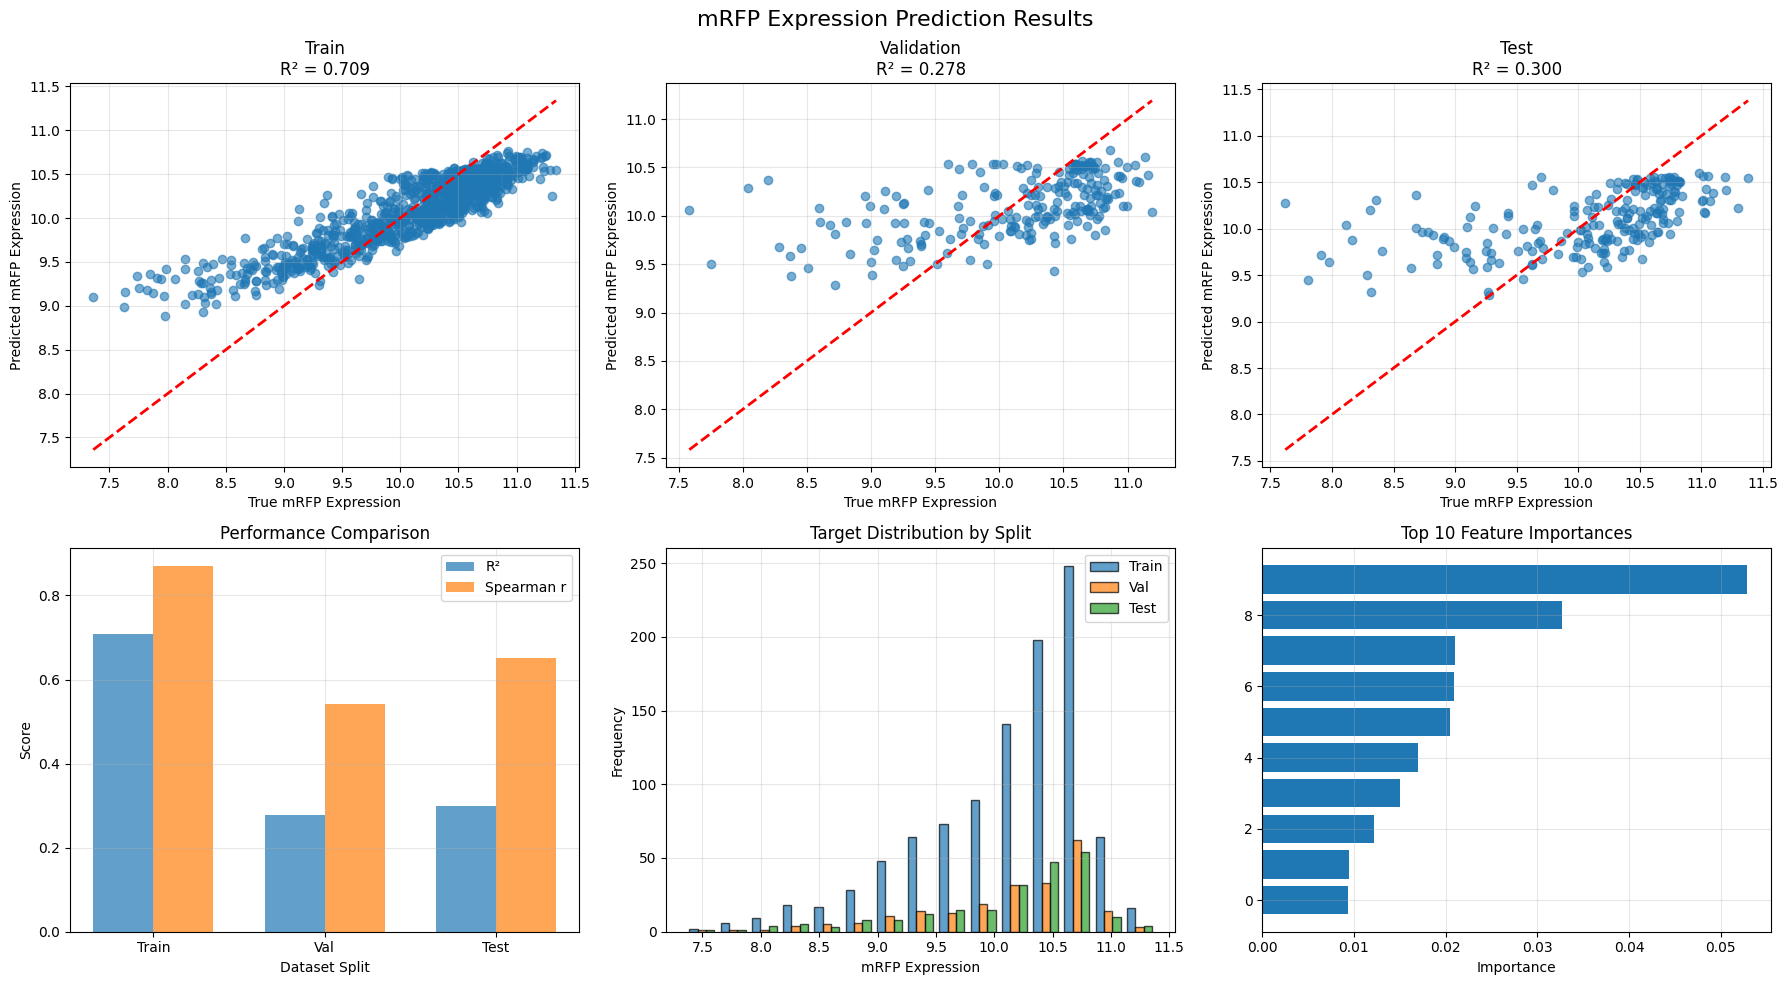

In [8]:
if "y_test" in locals():
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("mRFP Expression Prediction Results", fontsize=16)

    # Predicted vs True for all splits
    splits = [
        ("Train", y_train, y_pred_train, train_r2),
        ("Validation", y_val, y_pred_val, val_r2),
        ("Test", y_test, y_pred_test, test_r2),
    ]

    for i, (split_name, y_true, y_pred, r2) in enumerate(splits):
        axes[0, i].scatter(y_true, y_pred, alpha=0.6)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        axes[0, i].plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2)
        axes[0, i].set_xlabel("True mRFP Expression")
        axes[0, i].set_ylabel("Predicted mRFP Expression")
        axes[0, i].set_title(f"{split_name}\nR² = {r2:.3f}")
        axes[0, i].grid(True, alpha=0.3)

    # Performance comparison
    r2_scores = [train_r2, val_r2, test_r2]
    spearmanr_scores = [train_spearmanr, val_spearmanr, test_spearmanr]

    x_pos = np.arange(len(splits))
    width = 0.35

    axes[1, 0].bar(x_pos - width / 2, r2_scores, width, label="R²", alpha=0.7)
    axes[1, 0].bar(x_pos + width / 2, spearmanr_scores, width, label="Spearman r", alpha=0.7)
    axes[1, 0].set_xlabel("Dataset Split")
    axes[1, 0].set_ylabel("Score")
    axes[1, 0].set_title("Performance Comparison")
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(["Train", "Val", "Test"])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Target distribution across splits
    axes[1, 1].hist([y_train, y_val, y_test], bins=15, alpha=0.7, label=["Train", "Val", "Test"], edgecolor="black")
    axes[1, 1].set_xlabel("mRFP Expression")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].set_title("Target Distribution by Split")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Feature importance
    top_features = np.argsort(rf.feature_importances_)[-10:]
    axes[1, 2].barh(range(10), rf.feature_importances_[top_features])
    axes[1, 2].set_xlabel("Importance")
    axes[1, 2].set_title("Top 10 Feature Importances")
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("❌ No results to plot")

## 7. Troubleshooting & Optimization Tips

### Common Issues and Solutions:

#### 1. Model Loading Issues
- **Problem**: Checkpoint not found
- **Solution**: Update checkpoint paths in section 2
- **Check**: Verify checkpoint files exist and are accessible

#### 2. Data Loading Issues
- **Problem**: Dataset not found
- **Solution**: Update data paths in section 3
- **Check**: Ensure CSV files have required columns (id, ref_seq, value)

#### 3. Memory Issues
- **Problem**: CUDA out of memory
- **Solution**: Reduce batch_size in preprocessing section
- **Alternative**: Use CPU by setting device='cpu'

#### 4. Performance Issues
- **Problem**: Low R² scores
- **Solutions**:
  - Try larger models (600M or 1B parameters)
  - Implement fine-tuning instead of just embeddings
  - Tune Random Forest hyperparameters
  - Check data quality and preprocessing


### Optimization Strategies:

#### 1. Model Architecture
- **80M model**: Fast, good for initial experiments
- **600M model**: Better performance, moderate cost
- **1B model**: Best performance, highest computational cost

#### 3. Hyperparameter Tuning
```python
# Try these Random Forest parameters:
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
```